# Comparison between Tokyo and Osaka with Data Science

# 1. Introduction
Tokyo and Osaka are the two largest cities in Japan. You can find a lot of information from internet or books which introduce landmarks, restaurants, shopping streets, parks and so on. But I decided to explore the cities with different approach by using data science. What are the characteristics of Japan's two major cities? Are Tokyo and Osaka similar or not? Could data science find Interesting discovery?

# 2. Business Problem
Data science has a potential to tell us what people won't be able to notice and what is not written in books or magazines. The aim of this project is to provide new insights to tourists who are interested in Japan or to travel agencies who publish books or provide information on the internet.

# 3. Data Description
Special Wards of Tokyo is an inner city of Tokyo Prefecture and has 23 districts, whereas Osaka city is a center of Osaka Prefecture and has 24 districts. I will use clustering analysis methodology for each district and it's convenient that two cities have similar number of districts. In addition, below is basic comparison of Tokyo and Osaka, which could complement the results of data analysis (although I won't use these info in Python programming).

||Special Wards of Tokyo|Osaka City|
|:-|:-|:-|
|Population|9,659,769|2,750,812|
|Area|627.57km2|225.21km2|
|Population Density|15,392/km2|12,214/km2|
|Districts|23|24|

## 3.1 Data Source
For data source, names of all districts in Wards of Tokyo and Osaka city are necessary. Below Wikipedia pages provide the data as a table structure. There are so many information and data on these pages but the process for scraping is simplified thanks to Python BeautifulSoup library.

**Special Wards of Tokyo**<BR>
https://en.wikipedia.org/wiki/Tokyo<BR>

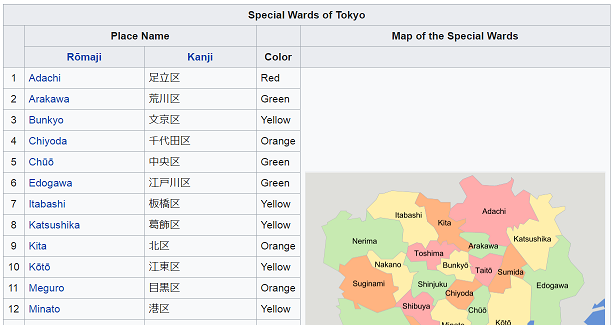

**Osaka city**<BR>
https://en.wikipedia.org/wiki/Osaka<BR>

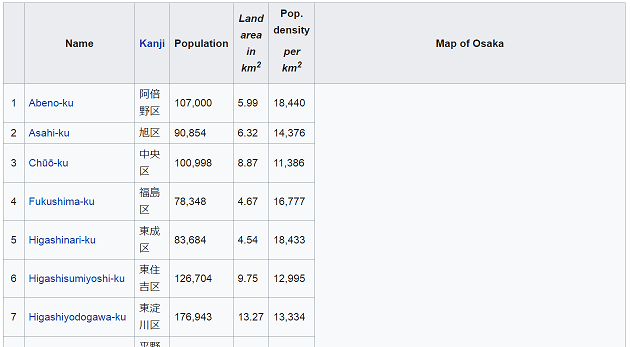

## 3.2 Data Processing Libraries
* [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/)<BR>
BeautifulSoup is a Python library for pulling data out of HTML and XML files. In this project, this library is used for scraping district table from Wikipedia website.<P>
* [Geocoding](https://geocoder.readthedocs.io/providers/Google.html)<BR>
Geocoding is the process of converting addresses into geographic coordinates of latitude and longitude. In this project, this library is used for converting each district name into latitude and longitude.<P>
* [Foursquare](https://foursquare.com/)<BR>
Foursquare is a technology company that build a massive dataset of accurate location data. Specific type of venues or stores around a given location can be searched by Foursquare API.

# 4. Methodology
This chapter consists of 2 parts. In the first part Tokyo and Osaka are clustered into 3 segments individually based on venues information for each districts and see what kinds of characteristics we could get. In the last part, clustering is done with mixed data of Tokyo and Osaka and see how the result is different with the first part.

## 4.1 Scrape district data of Tokyo and Osaka
First, import necessary libraries.

In [1]:
import pandas as pd # data analysis and manipulation tool
import numpy as np # general-purpose array-processing package
import requests # elegant and simple HTTP library
from bs4 import BeautifulSoup # library for pulling data out of HTML and XML files

Scrape districts table of Tokyo from Wikipedia and create pandas DataFrame. Confirmed tokyo DataFrame has 23 districts.

In [2]:
req = requests.get("https://en.wikipedia.org/wiki/Tokyo")
soup = BeautifulSoup(req.content,'lxml')
table = soup.find_all('table')[3] # 4th table describes special wards of Tokyo
df = pd.read_html(str(table))
tokyo = pd.DataFrame(df[0])
tokyo = tokyo.iloc[:, 1]
tokyo = pd.DataFrame(tokyo)
tokyo.columns = ['District']
print(tokyo.shape)
tokyo.head()

(23, 1)


,District
0,Adachi
1,Arakawa
2,Bunkyo
3,Chiyoda
4,Chūō


Scrape districts table of Osaka from Wikipedia and create pandas DataFrame. Confirmed osaka DataFrame has 24 districts.

In [3]:
req = requests.get("https://en.wikipedia.org/wiki/Osaka")
soup = BeautifulSoup(req.content,'lxml')
table = soup.find_all('table')[4] # 5th table describes wards of Osaka
df = pd.read_html(str(table))
osaka = pd.DataFrame(df[0])
osaka = osaka.iloc[:, 1]
osaka = pd.DataFrame(osaka)
osaka.columns = ['District']
print(osaka.shape)
osaka.head()

(24, 1)


,District
0,Abeno-ku
1,Asahi-ku
2,Chūō-ku
3,Fukushima-ku
4,Higashinari-ku


## 4.2 Get the list of latitude and longitude coordinates of a given district name
Import geocoder to convert district name to latitude and longitude.

In [4]:
!pip install geocoder
import geocoder

     |████████████████████████████████| 98 kB 4.5 MB/s eta 0:00:011


Get coordinates for each district in Tokyo, confirm tokyo DataFeame is updated with latitude and longitude coloumns.

In [5]:
lat_lng_coords = None
lati = []
longti = []
i = 0

# Repeated for each district name in tokyo DataFrame
for dist_name in tokyo['District']:
  # Repeated until
  while(lat_lng_coords is None):
    g = geocoder.arcgis('{}-ku, Tokyo, Japan'.format(tokyo.loc[i, 'District']))
    lat_lng_coords = g.latlng

  #print('District = {0}, Latitude = {1}, Longtitude = {2}'.format(District, lat_lng_coords[0], lat_lng_coords[1]))
  lati.append(lat_lng_coords[0])
  longti.append(lat_lng_coords[1])
  i = i + 1
  lat_lng_coords = None

tokyo['Latitude'] = lati
tokyo['Longtitude'] = longti
tokyo.head()

,District,Latitude,Longtitude
0,Adachi,35.774811,139.804537
1,Arakawa,35.736093,139.783403
2,Bunkyo,35.707595,139.752210
3,Chiyoda,35.693930,139.753711
4,Chūō,35.670572,139.771988


Get coordinates for each district in Osaka, confirm osaka DataFeame is updated with latitude and longitude coloumns.

In [6]:
lat_lng_coords = None
lati = []
longti = []
i = 0

# Repeated for each district name in osaka DataFrame
for dist_name in osaka['District']:
  while(lat_lng_coords is None):
    g = geocoder.arcgis('{}, Osaka city, Osaka'.format(osaka.loc[i, 'District']))
    lat_lng_coords = g.latlng

  #print('District = {0}, Latitude = {1}, Longtitude = {2}'.format(District, lat_lng_coords[0], lat_lng_coords[1]))
  lati.append(lat_lng_coords[0])
  longti.append(lat_lng_coords[1])
  i = i + 1
  lat_lng_coords = None

osaka['Latitude'] = lati
osaka['Longtitude'] = longti
osaka.head()

,District,Latitude,Longtitude
0,Abeno-ku,34.638732,135.518467
1,Asahi-ku,34.721168,135.544269
2,Chūō-ku,34.681144,135.509884
3,Fukushima-ku,34.692308,135.472220
4,Higashinari-ku,34.669951,135.541270


## 4.3 Get a map of Tokyo & Osaka and add markers to the map
Import Nominatim and get geograpical coordinate of Special Wards of Tokyo and Osaka City. These are used as the center coordinates of Tokyo and Osaka.

In [7]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode('Tokyo, Japan')
tokyo_latitude = location.latitude
tokyo_longitude = location.longitude
print('The geograpical coordinate of Tokyo are {}, {}.'.format(tokyo_latitude, tokyo_longitude))
location = geolocator.geocode('Osaka city, Japan')
osaka_latitude = location.latitude
osaka_longitude = location.longitude
print('The geograpical coordinate of Osaka are {}, {}.'.format(osaka_latitude, osaka_longitude))

The geograpical coordinate of Tokyo are 35.6828387, 139.7594549.
The geograpical coordinate of Osaka are 34.6937569, 135.5014539.


Import folium. Folium is used for visualizing geospatial data.

In [8]:
!pip install folium
import folium

     |████████████████████████████████| 93 kB 2.2 MB/s eta 0:00:011


Create the map of Tokyo/Osaka and add district marks to it.

In [9]:
tokyo_map = folium.Map(location=[tokyo_latitude, tokyo_longitude], zoom_start=11)

for dist, lat, lng in zip(tokyo['District'], tokyo['Latitude'], tokyo['Longtitude']):
    label = folium.Popup(dist, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(tokyo_map)  
    
tokyo_map

In [10]:
osaka_map = folium.Map(location=[osaka_latitude, osaka_longitude], zoom_start=11)

for dist, lat, lng in zip(osaka['District'], osaka['Latitude'], osaka['Longtitude']):
    label = folium.Popup(dist, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(osaka_map)  
    
osaka_map

## 4.4 Explore each district and get venues information
Use Foursquare API to explore and get venues around districts. First define a function to get nearby venues.

In [11]:
# The code was removed by Watson Studio for sharing.

In [12]:
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# Function : getNearbyVenues
# name : 
# latitudes : 
# longitudes : 
# radius : 
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Call getNearbyVenues function and create a new DataFrame tokyo_venue.

In [13]:
tokyo_venues = getNearbyVenues(names=tokyo['District'], latitudes=tokyo['Latitude'], longitudes=tokyo['Longtitude'])
print(tokyo_venues.shape)
tokyo_venues.head()

Adachi
Arakawa
Bunkyo
Chiyoda
Chūō
Edogawa
Itabashi
Katsushika
Kita
Kōtō
Meguro
Minato
Nakano
Nerima
Ōta
Setagaya
Shibuya
Shinagawa
Shinjuku
Suginami
Sumida
Taitō
Toshima
(1523, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adachi,35.774811,139.804537,MEGA Don Quijote (MEGAドン・キホーテ 環七梅島店),35.778288,139.804967,Discount Store
1,Adachi,35.774811,139.804537,Ikinari Steak (いきなり!ステーキ),35.777730,139.802890,Steakhouse
2,Adachi,35.774811,139.804537,Nitori (ニトリ),35.778200,139.802592,Furniture / Home Store
3,Adachi,35.774811,139.804537,Yoshinoya (吉野家),35.773290,139.803560,Donburi Restaurant
4,Adachi,35.774811,139.804537,7-Eleven (セブンイレブン 足立梅島1丁目店),35.771822,139.803176,Convenience Store


Call getNearbyVenues function and create a new DataFrame osaka_venue.

In [16]:
osaka_venues = getNearbyVenues(names=osaka['District'], latitudes=osaka['Latitude'], longitudes=osaka['Longtitude'])
print(osaka_venues.shape)
osaka_venues.head()

Abeno-ku
Asahi-ku
Chūō-ku
Fukushima-ku
Higashinari-ku
Higashisumiyoshi-ku
Higashiyodogawa-ku
Hirano-ku
Ikuno-ku
Jōtō-ku
Kita-ku (administrative center)
Konohana-ku
Minato-ku
Miyakojima-ku
Naniwa-ku
Nishi-ku
Nishinari-ku
Nishiyodogawa-ku
Suminoe-ku
Sumiyoshi-ku
Taishō-ku
Tennōji-ku
Tsurumi-ku
Yodogawa-ku
(774, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abeno-ku,34.638732,135.518467,FamilyMart (ファミリーマート 松崎町店),34.639983,135.517041,Convenience Store
1,Abeno-ku,34.638732,135.518467,Royal Host (ロイヤルホスト 文の里店),34.637175,135.517652,Restaurant
2,Abeno-ku,34.638732,135.518467,甘辛や,34.638189,135.522473,Okonomiyaki Restaurant
3,Abeno-ku,34.638732,135.518467,FamilyMart (ファミリーマート 文の里二丁目店),34.636626,135.517734,Convenience Store
4,Abeno-ku,34.638732,135.518467,Gusto (ガスト 文の里店),34.639614,135.518109,Restaurant


New DataFrame generated by getNearbyVenues function has 7 columns shown above. Foursquare API searches for venues within a radius of 500 meters from specified district latitude and longitude. Maximum number of venues for one district are limited to 100.

## 4.5 Number of venues for Tokyo and Osaka

In [17]:
tokyo_venues.groupby('District').count()['Venue']

District
Adachi         21
Arakawa        15
Bunkyo        100
Chiyoda       100
Chūō          100
Edogawa        33
Itabashi       41
Katsushika     29
Kita           35
Kōtō           72
Meguro         90
Minato         90
Nakano        100
Nerima         56
Setagaya       39
Shibuya       100
Shinagawa      56
Shinjuku      100
Suginami       31
Sumida         74
Taitō          76
Toshima        93
Ōta            72
Name: Venue, dtype: int64

In [18]:
osaka_venues.groupby('District').count()['Venue']

District
Abeno-ku                           22
Asahi-ku                           15
Chūō-ku                            64
Fukushima-ku                       50
Higashinari-ku                     30
Higashisumiyoshi-ku                16
Higashiyodogawa-ku                 46
Hirano-ku                          20
Ikuno-ku                           11
Jōtō-ku                            42
Kita-ku (administrative center)    73
Konohana-ku                        11
Minato-ku                          27
Miyakojima-ku                      26
Naniwa-ku                          54
Nishi-ku                           46
Nishinari-ku                       36
Nishiyodogawa-ku                   22
Suminoe-ku                         17
Sumiyoshi-ku                       17
Taishō-ku                          23
Tennōji-ku                         26
Tsurumi-ku                         19
Yodogawa-ku                        61
Name: Venue, dtype: int64

In [19]:
print('Total number of venues in Tokyo is', len(tokyo_venues))
print('Total number of venues in Osaka is', len(osaka_venues))

Total number of venues in Tokyo is 1523
Total number of venues in Osaka is 774


The population density ratio between Tokyo and Osaka is 5 : 4 (15,392/km2 : 12,214/km2) whereas the number of venues ratio is 2 : 1 (1524 : 774). Moreover, the number of venue is reached the maximum of 100 in some districts in Tokyo, which means data shows how Tokyo's venues are dense.

## 4.6 Apply one-hot-encode to Venue Category
Venue Category in tokyo_venues and osaka_venues DataFrame is described as type of strings. These strings should be converted to numerical value as clustering algorithm can't take care of string data.

In [20]:
# one hot encoding
tokyo_onehot = pd.get_dummies(tokyo_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
tokyo_onehot['District'] = tokyo_venues['District']

# move district column to the first column
fixed_columns = [tokyo_onehot.columns[-1]] + list(tokyo_onehot.columns[:-1])
tokyo_onehot = tokyo_onehot[fixed_columns]
tokyo_onehot.head()

,District,ATM,Accessories Store,African Restaurant,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Vietnamese Restaurant,Wagashi Place,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Zoo
0,Adachi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adachi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adachi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adachi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adachi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# one hot encoding
osaka_onehot = pd.get_dummies(osaka_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
osaka_onehot['District'] = osaka_venues['District']

# move district column to the first column
fixed_columns = [osaka_onehot.columns[-1]] + list(osaka_onehot.columns[:-1])
osaka_onehot = osaka_onehot[fixed_columns]
osaka_onehot.head()

,District,ATM,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bar,Baseball Field,Bath House,...,Video Store,Vietnamese Restaurant,Wagashi Place,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoshoku Restaurant
0,Abeno-ku,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Abeno-ku,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Abeno-ku,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Abeno-ku,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Abeno-ku,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create new DataFrame **tokyo_grouped** and **osaka_grouped** which rows are grouped by District and the sum value for each venue is averaged.

In [22]:
tokyo_grouped = tokyo_onehot.groupby('District').mean().reset_index()
tokyo_grouped.head()

,District,ATM,Accessories Store,African Restaurant,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Vietnamese Restaurant,Wagashi Place,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Zoo
0,Adachi,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0
1,Arakawa,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0
2,Bunkyo,0.00,0.0,0.0,0.01,0.0,0.01,0.01,0.00,0.00,...,0.0,0.0,0.0,0.00,0.0,0.0,0.01,0.0,0.02,0.0
3,Chiyoda,0.01,0.0,0.0,0.00,0.0,0.00,0.00,0.02,0.00,...,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.01,0.0
4,Chūō,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.01,...,0.0,0.0,0.0,0.03,0.0,0.0,0.01,0.0,0.03,0.0


In [23]:
osaka_grouped = osaka_onehot.groupby('District').mean().reset_index()
osaka_grouped.head()

,District,ATM,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bar,Baseball Field,Bath House,...,Video Store,Vietnamese Restaurant,Wagashi Place,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoshoku Restaurant
0,Abeno-ku,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.0,0.000000
1,Asahi-ku,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.066667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2,Chūō-ku,0.00,0.0,0.0,0.000000,0.015625,0.015625,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.015625
3,Fukushima-ku,0.02,0.0,0.0,0.000000,0.060000,0.020000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
4,Higashinari-ku,0.00,0.0,0.0,0.033333,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


## 4.7 Frequency of appearance of venue categories for Tokyo and Osaka
Let's see top 5 venue categories for each districts.

In [24]:
num_top_venues = 5

for hood in tokyo_grouped['District']:
    print("----"+hood+"----")
    temp = tokyo_grouped[tokyo_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adachi----
                    venue  freq
0       Convenience Store  0.19
1           Grocery Store  0.10
2                Pharmacy  0.05
3        Ramen Restaurant  0.05
4  Furniture / Home Store  0.05


----Arakawa----
                venue  freq
0                Park  0.13
1   Convenience Store  0.13
2            Bus Stop  0.13
3  Italian Restaurant  0.07
4  Chinese Restaurant  0.07


----Bunkyo----
                 venue  freq
0     Baseball Stadium  0.08
1    Convenience Store  0.05
2   Italian Restaurant  0.04
3     Ramen Restaurant  0.04
4  Japanese Restaurant  0.03


----Chiyoda----
                venue  freq
0                Café  0.10
1  Chinese Restaurant  0.08
2         Coffee Shop  0.06
3    Ramen Restaurant  0.06
4   Convenience Store  0.06


----Chūō----
                 venue  freq
0  Japanese Restaurant  0.09
1      Soba Restaurant  0.08
2     Sushi Restaurant  0.06
3     Ramen Restaurant  0.06
4          Coffee Shop  0.05


----Edogawa----
                venue  

In [25]:
num_top_venues = 5

for hood in osaka_grouped['District']:
    print("----"+hood+"----")
    temp = osaka_grouped[osaka_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abeno-ku----
                 venue  freq
0    Convenience Store  0.18
1  Japanese Restaurant  0.14
2           Restaurant  0.09
3                 Park  0.05
4      Udon Restaurant  0.05


----Asahi-ku----
               venue  freq
0  Convenience Store  0.27
1   Ramen Restaurant  0.13
2    Udon Restaurant  0.07
3           Sake Bar  0.07
4             Casino  0.07


----Chūō-ku----
                       venue  freq
0          Convenience Store  0.20
1        Japanese Restaurant  0.09
2  Japanese Curry Restaurant  0.08
3                Coffee Shop  0.06
4              Shopping Mall  0.05


----Fukushima-ku----
                  venue  freq
0     Convenience Store  0.20
1  Fast Food Restaurant  0.08
2             BBQ Joint  0.06
3      Ramen Restaurant  0.06
4    Donburi Restaurant  0.06


----Higashinari-ku----
                venue  freq
0   Convenience Store  0.27
1  Chinese Restaurant  0.10
2            Sake Bar  0.07
3  Donburi Restaurant  0.07
4         Supermarket  0.07


--

Next, combine every venue categories for Tokyo and Osaka then display top 10 categories.

In [26]:
temp = tokyo_grouped.iloc[:,1:].sum().sort_values(ascending=False)
temp2 = temp.sum()
tokyo_lank = temp.head(10)/temp2
print('-----Tokyo-----')
print(tokyo_lank)

print('\n-----Osaka-----')
temp = osaka_grouped.iloc[:,1:].sum().sort_values(ascending=False)
temp2 = temp.sum()
osaka_lank = temp.head(10)/temp2
print(osaka_lank)

-----Tokyo-----
Convenience Store      0.090672
Ramen Restaurant       0.064845
Japanese Restaurant    0.046560
Sake Bar               0.038315
Café                   0.038268
Chinese Restaurant     0.031057
BBQ Joint              0.023400
Coffee Shop            0.022602
Grocery Store          0.021414
Park                   0.021324
dtype: float64

-----Osaka-----
Convenience Store      0.245561
Ramen Restaurant       0.041037
Japanese Restaurant    0.039152
Grocery Store          0.030565
Donburi Restaurant     0.029944
Intersection           0.029529
Chinese Restaurant     0.028739
Sake Bar               0.027923
Park                   0.024438
Shopping Mall          0.024214
dtype: float64


Use bar graph and plot data.

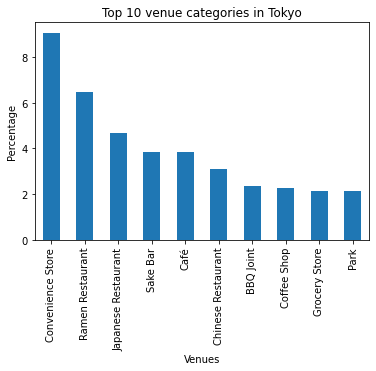

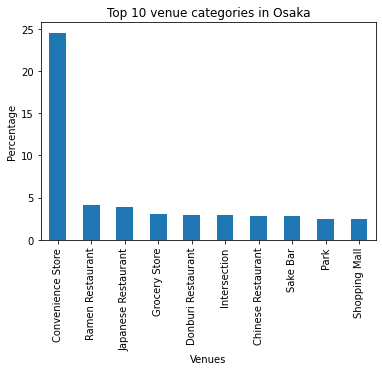

In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt

tokyo_lank = tokyo_lank*100
tokyo_lank.plot(kind='bar')
plt.title('Top 10 venue categories in Tokyo')
plt.xlabel('Venues')
plt.ylabel('Percentage')
plt.show()

osaka_lank = osaka_lank*100
osaka_lank.plot(kind='bar')
plt.title('Top 10 venue categories in Osaka')
plt.xlabel('Venues')
plt.ylabel('Percentage')
plt.show()

It looks like Japanese cities are occupied by a convenience stores, especially in Osaka city (about 25% is convenience stores!). Another interesting characteristic is 2nd place of Ramen restaurant for both Tokyo and Osaka. Believe me, Japanese Ramen is amazing!

## 4.8 Create a new dataframe which contains top 10 venues categories
Define a function that returns top venues from input DataFrame.

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a new DataFrame called tokyo_venues_sorted and osaka_venues_sorted that have top 10 venues.

In [29]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Venue'.format(ind+1))

# create a new dataframe
tokyo_venues_sorted = pd.DataFrame(columns=columns)
tokyo_venues_sorted['District'] = tokyo_grouped['District']

for ind in np.arange(tokyo_grouped.shape[0]):
    tokyo_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tokyo_grouped.iloc[ind, :], num_top_venues)

tokyo_venues_sorted.head()

,District,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
0,Adachi,Convenience Store,Grocery Store,Ramen Restaurant,Bus Stop,Furniture / Home Store,Music Venue,Pharmacy,Tourist Information Center,Bakery,BBQ Joint
1,Arakawa,Bus Stop,Park,Convenience Store,Grocery Store,Asian Restaurant,Café,Chinese Restaurant,Bath House,Concert Hall,Tram Station
2,Bunkyo,Baseball Stadium,Convenience Store,Italian Restaurant,Ramen Restaurant,Theme Park Ride / Attraction,Concert Hall,Japanese Restaurant,BBQ Joint,Coffee Shop,Bed & Breakfast
3,Chiyoda,Café,Chinese Restaurant,Ramen Restaurant,Coffee Shop,Convenience Store,Sake Bar,Japanese Curry Restaurant,Historic Site,Indian Restaurant,Soba Restaurant
4,Chūō,Japanese Restaurant,Soba Restaurant,Ramen Restaurant,Sushi Restaurant,Coffee Shop,Italian Restaurant,Yoshoku Restaurant,Chinese Restaurant,Convenience Store,Kaiseki Restaurant


In [30]:
# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Venue'.format(ind+1))

# create a new dataframe
osaka_venues_sorted = pd.DataFrame(columns=columns)
osaka_venues_sorted['District'] = osaka_grouped['District']

for ind in np.arange(osaka_grouped.shape[0]):
    osaka_venues_sorted.iloc[ind, 1:] = return_most_common_venues(osaka_grouped.iloc[ind, :], num_top_venues)

osaka_venues_sorted.head()

,District,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
0,Abeno-ku,Convenience Store,Japanese Restaurant,Restaurant,Diner,Train Station,Intersection,Sake Bar,Fast Food Restaurant,Pharmacy,Pastry Shop
1,Asahi-ku,Convenience Store,Ramen Restaurant,Sake Bar,Udon Restaurant,Park,Casino,Café,Grocery Store,Theater,Restaurant
2,Chūō-ku,Convenience Store,Japanese Restaurant,Japanese Curry Restaurant,Coffee Shop,Shopping Mall,Café,Italian Restaurant,French Restaurant,Ramen Restaurant,Yoshoku Restaurant
3,Fukushima-ku,Convenience Store,Fast Food Restaurant,BBQ Joint,Donburi Restaurant,Ramen Restaurant,Supermarket,Train Station,Chinese Restaurant,Shopping Mall,Bookstore
4,Higashinari-ku,Convenience Store,Chinese Restaurant,Supermarket,Japanese Restaurant,Donburi Restaurant,Sake Bar,Ramen Restaurant,Park,Grocery Store,Coffee Shop


In [31]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 3

## 4.9 Run k-means clustering with grouped DataFrame
Set number of clusters to 3, it's appropriate number since the number of districts is only 23 for Tokyo and 24 for Osaka.

Create new DataFrame named **tokyo_grouped_clustering** and **osaka_grouped_clustering** which drop District colomn then apply k-means clustering.

In [32]:
tokyo_grouped_clustering = tokyo_grouped.drop('District', 1)

# run k-means clustering
tokyo_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tokyo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
tokyo_kmeans.labels_

array([1, 0, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2,
       2], dtype=int32)

In [33]:
osaka_grouped_clustering = osaka_grouped.drop('District', 1)

# run k-means clustering
osaka_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(osaka_grouped_clustering)

# check cluster labels generated for each row in the dataframe
osaka_kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 1, 0, 0, 2, 0, 0, 1, 1, 1, 0, 2,
       1, 2], dtype=int32)

Build final DataFrame.

In [34]:
# Merge tokyo_grouped with tokyo to add latitude/longitude for each neighborhood
tokyo_venues_sorted.insert(0, 'Cluster Labels', tokyo_kmeans.labels_)
tokyo_merged = tokyo
tokyo_merged = tokyo_merged.join(tokyo_venues_sorted.set_index('District'), on='District')
tokyo_merged.head()

,District,Latitude,Longtitude,Cluster Labels,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
0,Adachi,35.774811,139.804537,1,Convenience Store,Grocery Store,Ramen Restaurant,Bus Stop,Furniture / Home Store,Music Venue,Pharmacy,Tourist Information Center,Bakery,BBQ Joint
1,Arakawa,35.736093,139.783403,0,Bus Stop,Park,Convenience Store,Grocery Store,Asian Restaurant,Café,Chinese Restaurant,Bath House,Concert Hall,Tram Station
2,Bunkyo,35.707595,139.752210,2,Baseball Stadium,Convenience Store,Italian Restaurant,Ramen Restaurant,Theme Park Ride / Attraction,Concert Hall,Japanese Restaurant,BBQ Joint,Coffee Shop,Bed & Breakfast
3,Chiyoda,35.693930,139.753711,2,Café,Chinese Restaurant,Ramen Restaurant,Coffee Shop,Convenience Store,Sake Bar,Japanese Curry Restaurant,Historic Site,Indian Restaurant,Soba Restaurant
4,Chūō,35.670572,139.771988,2,Japanese Restaurant,Soba Restaurant,Ramen Restaurant,Sushi Restaurant,Coffee Shop,Italian Restaurant,Yoshoku Restaurant,Chinese Restaurant,Convenience Store,Kaiseki Restaurant


In [35]:
# Merge osaka_grouped with osaka to add latitude/longitude for each neighborhood
osaka_venues_sorted.insert(0, 'Cluster Labels', osaka_kmeans.labels_)
osaka_merged = osaka
osaka_merged = osaka_merged.join(osaka_venues_sorted.set_index('District'), on='District')
osaka_merged.head()

,District,Latitude,Longtitude,Cluster Labels,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
0,Abeno-ku,34.638732,135.518467,0,Convenience Store,Japanese Restaurant,Restaurant,Diner,Train Station,Intersection,Sake Bar,Fast Food Restaurant,Pharmacy,Pastry Shop
1,Asahi-ku,34.721168,135.544269,0,Convenience Store,Ramen Restaurant,Sake Bar,Udon Restaurant,Park,Casino,Café,Grocery Store,Theater,Restaurant
2,Chūō-ku,34.681144,135.509884,0,Convenience Store,Japanese Restaurant,Japanese Curry Restaurant,Coffee Shop,Shopping Mall,Café,Italian Restaurant,French Restaurant,Ramen Restaurant,Yoshoku Restaurant
3,Fukushima-ku,34.692308,135.472220,0,Convenience Store,Fast Food Restaurant,BBQ Joint,Donburi Restaurant,Ramen Restaurant,Supermarket,Train Station,Chinese Restaurant,Shopping Mall,Bookstore
4,Higashinari-ku,34.669951,135.541270,0,Convenience Store,Chinese Restaurant,Supermarket,Japanese Restaurant,Donburi Restaurant,Sake Bar,Ramen Restaurant,Park,Grocery Store,Coffee Shop


## 4.10 Create clusters map

In [36]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# create map
tokyo_clusters = folium.Map(location=[tokyo_latitude, tokyo_longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tokyo_merged['Latitude'], tokyo_merged['Longtitude'], tokyo_merged['District'], tokyo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(tokyo_clusters)
       
tokyo_clusters

In [37]:
# create map
osaka_clusters = folium.Map(location=[osaka_latitude, osaka_longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(osaka_merged['Latitude'], osaka_merged['Longtitude'], osaka_merged['District'], osaka_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(osaka_clusters)
       
osaka_clusters

There’s a trend that purple mark shows outer districts, but we are not sure the relation between 2 cities as individual data set is used for clustering.

## 4.11 Analyze Clusters

In [38]:
# Tokyo Cluster 1
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 0, tokyo_merged.columns[[0] + list(range(4, tokyo_merged.shape[1]))]]

,District,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
1,Arakawa,Bus Stop,Park,Convenience Store,Grocery Store,Asian Restaurant,Café,Chinese Restaurant,Bath House,Concert Hall,Tram Station


In [39]:
# Tokyo Cluster 2
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 1, tokyo_merged.columns[[0] + list(range(4, tokyo_merged.shape[1]))]]

,District,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
0,Adachi,Convenience Store,Grocery Store,Ramen Restaurant,Bus Stop,Furniture / Home Store,Music Venue,Pharmacy,Tourist Information Center,Bakery,BBQ Joint
5,Edogawa,Convenience Store,Concert Hall,Drugstore,Grocery Store,Donburi Restaurant,Electronics Store,Japanese Restaurant,Cultural Center,Rental Car Location,Bowling Alley
6,Itabashi,Convenience Store,Ramen Restaurant,Japanese Restaurant,Chinese Restaurant,Shopping Mall,Grocery Store,Zoo,Bus Stop,Café,Dessert Shop
7,Katsushika,Intersection,Convenience Store,Bus Stop,Supermarket,Discount Store,Japanese Restaurant,Sushi Restaurant,Japanese Family Restaurant,Grocery Store,Electronics Store
8,Kita,Convenience Store,Ramen Restaurant,Intersection,Park,Café,Theater,Bed & Breakfast,Steakhouse,Fried Chicken Joint,Takoyaki Place
9,Kōtō,Convenience Store,Sake Bar,Coffee Shop,Ramen Restaurant,Chinese Restaurant,Park,Japanese Restaurant,Café,Bed & Breakfast,Sushi Restaurant
13,Nerima,Ramen Restaurant,Convenience Store,Sake Bar,Grocery Store,Chinese Restaurant,Drugstore,BBQ Joint,Italian Restaurant,Takoyaki Place,Burger Joint
15,Setagaya,Convenience Store,Café,Sake Bar,Bakery,Ramen Restaurant,Intersection,Dumpling Restaurant,Supermarket,Szechuan Restaurant,Outdoor Sculpture
17,Shinagawa,Convenience Store,Japanese Restaurant,Donburi Restaurant,Ramen Restaurant,Coffee Shop,Steakhouse,Park,BBQ Joint,Theater,Italian Restaurant


In [40]:
# Tokyo Cluster 3
tokyo_merged.loc[tokyo_merged['Cluster Labels'] == 2, tokyo_merged.columns[[0] + list(range(4, tokyo_merged.shape[1]))]]

,District,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
2,Bunkyo,Baseball Stadium,Convenience Store,Italian Restaurant,Ramen Restaurant,Theme Park Ride / Attraction,Concert Hall,Japanese Restaurant,BBQ Joint,Coffee Shop,Bed & Breakfast
3,Chiyoda,Café,Chinese Restaurant,Ramen Restaurant,Coffee Shop,Convenience Store,Sake Bar,Japanese Curry Restaurant,Historic Site,Indian Restaurant,Soba Restaurant
4,Chūō,Japanese Restaurant,Soba Restaurant,Ramen Restaurant,Sushi Restaurant,Coffee Shop,Italian Restaurant,Yoshoku Restaurant,Chinese Restaurant,Convenience Store,Kaiseki Restaurant
10,Meguro,Japanese Restaurant,Ramen Restaurant,BBQ Joint,Café,Italian Restaurant,Japanese Curry Restaurant,Chinese Restaurant,Coffee Shop,Bakery,Beer Bar
11,Minato,Japanese Restaurant,Ramen Restaurant,Chinese Restaurant,BBQ Joint,Convenience Store,Hotel,Tonkatsu Restaurant,Historic Site,Thai Restaurant,Coffee Shop
12,Nakano,Ramen Restaurant,Sake Bar,Japanese Restaurant,Café,BBQ Joint,Italian Restaurant,Japanese Curry Restaurant,Seafood Restaurant,Udon Restaurant,Teishoku Restaurant
14,Ōta,Ramen Restaurant,Japanese Restaurant,Sake Bar,Chinese Restaurant,Sushi Restaurant,Bed & Breakfast,Café,Tonkatsu Restaurant,BBQ Joint,Vietnamese Restaurant
16,Shibuya,Café,Record Shop,Nightclub,Rock Club,Japanese Restaurant,Chinese Restaurant,Ramen Restaurant,Concert Hall,Sake Bar,Clothing Store
18,Shinjuku,Sake Bar,Ramen Restaurant,BBQ Joint,Bar,Rock Club,Pub,Japanese Restaurant,Teishoku Restaurant,Beer Bar,Thai Restaurant
19,Suginami,Ramen Restaurant,Italian Restaurant,Café,Soba Restaurant,Sake Bar,Dumpling Restaurant,Event Space,Convenience Store,Park,Shopping Mall


In [41]:
# Osaka Cluster 1
osaka_merged.loc[osaka_merged['Cluster Labels'] == 0, osaka_merged.columns[[0] + list(range(4, osaka_merged.shape[1]))]]

,District,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
0,Abeno-ku,Convenience Store,Japanese Restaurant,Restaurant,Diner,Train Station,Intersection,Sake Bar,Fast Food Restaurant,Pharmacy,Pastry Shop
1,Asahi-ku,Convenience Store,Ramen Restaurant,Sake Bar,Udon Restaurant,Park,Casino,Café,Grocery Store,Theater,Restaurant
2,Chūō-ku,Convenience Store,Japanese Restaurant,Japanese Curry Restaurant,Coffee Shop,Shopping Mall,Café,Italian Restaurant,French Restaurant,Ramen Restaurant,Yoshoku Restaurant
3,Fukushima-ku,Convenience Store,Fast Food Restaurant,BBQ Joint,Donburi Restaurant,Ramen Restaurant,Supermarket,Train Station,Chinese Restaurant,Shopping Mall,Bookstore
4,Higashinari-ku,Convenience Store,Chinese Restaurant,Supermarket,Japanese Restaurant,Donburi Restaurant,Sake Bar,Ramen Restaurant,Park,Grocery Store,Coffee Shop
5,Higashisumiyoshi-ku,Convenience Store,Bar,Dessert Shop,Liquor Store,Supermarket,Restaurant,Motorcycle Shop,Shopping Mall,Grocery Store,Bakery
6,Higashiyodogawa-ku,Convenience Store,Ramen Restaurant,Sushi Restaurant,Pet Store,Donburi Restaurant,Thrift / Vintage Store,Supermarket,Bookstore,Indian Restaurant,Furniture / Home Store
12,Minato-ku,Convenience Store,Japanese Restaurant,Supermarket,Fast Food Restaurant,Mobile Phone Shop,Chinese Restaurant,Pachinko Parlor,Office,Pharmacy,Restaurant
13,Miyakojima-ku,Convenience Store,Japanese Restaurant,Grocery Store,Boat or Ferry,Hotel,Chinese Restaurant,Steakhouse,Sporting Goods Shop,Pizza Place,Motel
15,Nishi-ku,Convenience Store,Ramen Restaurant,Intersection,Japanese Restaurant,Café,Sake Bar,Park,Metro Station,Noodle House,Chinese Restaurant


In [42]:
# Osaka Cluster 2
osaka_merged.loc[osaka_merged['Cluster Labels'] == 1, osaka_merged.columns[[0] + list(range(4, osaka_merged.shape[1]))]]

,District,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
7,Hirano-ku,Convenience Store,Dumpling Restaurant,Ramen Restaurant,Pharmacy,Food,Hot Spring,Video Store,Fast Food Restaurant,Donburi Restaurant,BBQ Joint
11,Konohana-ku,Convenience Store,Chinese Restaurant,Donburi Restaurant,Shopping Mall,Ramen Restaurant,Café,French Restaurant,Golf Driving Range,German Restaurant,Garden
17,Nishiyodogawa-ku,Convenience Store,Discount Store,Optical Shop,Home Service,Ramen Restaurant,Fast Food Restaurant,Pizza Place,Clothing Store,Sushi Restaurant,Chinese Restaurant
18,Suminoe-ku,Convenience Store,Shopping Mall,ATM,Sports Club,Bus Stop,Park,Food & Drink Shop,Japanese Restaurant,Donburi Restaurant,River
19,Sumiyoshi-ku,Convenience Store,Café,Train Station,Fast Food Restaurant,Electronics Store,Asian Restaurant,Park,Grocery Store,Clothing Store,Bath House
22,Tsurumi-ku,Convenience Store,Intersection,Sake Bar,Metro Station,Drugstore,Supermarket,Motorcycle Shop,Dessert Shop,Grocery Store,Fast Food Restaurant


In [43]:
# Osaka Cluster 3
osaka_merged.loc[osaka_merged['Cluster Labels'] == 2, osaka_merged.columns[[0] + list(range(4, osaka_merged.shape[1]))]]

,District,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
8,Ikuno-ku,Grocery Store,Shopping Mall,Park,Convenience Store,Udon Restaurant,Bath House,Video Store,Sake Bar,Intersection,Japanese Restaurant
9,Jōtō-ku,Convenience Store,Ramen Restaurant,Restaurant,BBQ Joint,Coffee Shop,Park,Fast Food Restaurant,Platform,Noodle House,Pharmacy
10,Kita-ku (administrative center),Coffee Shop,Convenience Store,Train Station,Hotel,Café,Udon Restaurant,Historic Site,Italian Restaurant,Japanese Restaurant,Thai Restaurant
14,Naniwa-ku,Ramen Restaurant,Convenience Store,BBQ Joint,Sake Bar,Coffee Shop,Hobby Shop,Dance Studio,Café,Korean Restaurant,Rock Club
21,Tennōji-ku,Platform,Coffee Shop,Grocery Store,Convenience Store,Lake,Tourist Information Center,Steakhouse,Buddhist Temple,Park,Metro Station
23,Yodogawa-ku,Convenience Store,Sake Bar,Ramen Restaurant,Donburi Restaurant,Chinese Restaurant,Shopping Mall,Wagashi Place,Bakery,Platform,Discount Store


## 4.12 Run k-means clustering with mixing Tokyo and Osaka DataFrame
The last clusters are made separately by Tokyo and Osaka. This time new k-means clustering will be applied to new DataFrame with mixed data of Tokyo and Osaka.

In [44]:
# Append Osaka data to Tokyo data
mixed_grouped_clustering = tokyo_grouped_clustering.append(osaka_grouped_clustering)
mixed_grouped_clustering.reset_index(inplace=True, drop=True)
mixed_grouped_clustering.fillna(0, inplace=True)

# run k-means clustering
mixed_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mixed_grouped_clustering)

# check cluster labels generated for each row in the dataframe
mixed_kmeans.labels_

array([2, 2, 1, 1, 1, 0, 0, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 1, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0,
       1, 0, 2], dtype=int32)

In [45]:
# Merge tokyo_grouped with tokyo to add latitude/longitude for each neighborhood
tokyo_venues_sorted2 = tokyo_venues_sorted.drop('Cluster Labels', axis=1) # Drop old 'Cluster Labels'
tokyo_venues_sorted2.insert(0, 'Cluster Labels', mixed_kmeans.labels_[0:23]) # Attach new 'Cluster Labels'
tokyo_merged2 = tokyo
tokyo_merged2 = tokyo_merged2.join(tokyo_venues_sorted2.set_index('District'), on='District')
tokyo_merged2.head()

,District,Latitude,Longtitude,Cluster Labels,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
0,Adachi,35.774811,139.804537,2,Convenience Store,Grocery Store,Ramen Restaurant,Bus Stop,Furniture / Home Store,Music Venue,Pharmacy,Tourist Information Center,Bakery,BBQ Joint
1,Arakawa,35.736093,139.783403,2,Bus Stop,Park,Convenience Store,Grocery Store,Asian Restaurant,Café,Chinese Restaurant,Bath House,Concert Hall,Tram Station
2,Bunkyo,35.707595,139.752210,1,Baseball Stadium,Convenience Store,Italian Restaurant,Ramen Restaurant,Theme Park Ride / Attraction,Concert Hall,Japanese Restaurant,BBQ Joint,Coffee Shop,Bed & Breakfast
3,Chiyoda,35.693930,139.753711,1,Café,Chinese Restaurant,Ramen Restaurant,Coffee Shop,Convenience Store,Sake Bar,Japanese Curry Restaurant,Historic Site,Indian Restaurant,Soba Restaurant
4,Chūō,35.670572,139.771988,1,Japanese Restaurant,Soba Restaurant,Ramen Restaurant,Sushi Restaurant,Coffee Shop,Italian Restaurant,Yoshoku Restaurant,Chinese Restaurant,Convenience Store,Kaiseki Restaurant


In [46]:
# Merge tokyo_grouped with tokyo to add latitude/longitude for each neighborhood
osaka_venues_sorted2 = osaka_venues_sorted.drop('Cluster Labels', axis=1) # Drop old 'Cluster Labels'
osaka_venues_sorted2.insert(0, 'Cluster Labels', mixed_kmeans.labels_[23:47]) # Attach new 'Cluster Labels'
osaka_merged2 = osaka
osaka_merged2 = osaka_merged2.join(osaka_venues_sorted2.set_index('District'), on='District')
osaka_merged2.head()

,District,Latitude,Longtitude,Cluster Labels,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
0,Abeno-ku,34.638732,135.518467,2,Convenience Store,Japanese Restaurant,Restaurant,Diner,Train Station,Intersection,Sake Bar,Fast Food Restaurant,Pharmacy,Pastry Shop
1,Asahi-ku,34.721168,135.544269,2,Convenience Store,Ramen Restaurant,Sake Bar,Udon Restaurant,Park,Casino,Café,Grocery Store,Theater,Restaurant
2,Chūō-ku,34.681144,135.509884,2,Convenience Store,Japanese Restaurant,Japanese Curry Restaurant,Coffee Shop,Shopping Mall,Café,Italian Restaurant,French Restaurant,Ramen Restaurant,Yoshoku Restaurant
3,Fukushima-ku,34.692308,135.472220,2,Convenience Store,Fast Food Restaurant,BBQ Joint,Donburi Restaurant,Ramen Restaurant,Supermarket,Train Station,Chinese Restaurant,Shopping Mall,Bookstore
4,Higashinari-ku,34.669951,135.541270,0,Convenience Store,Chinese Restaurant,Supermarket,Japanese Restaurant,Donburi Restaurant,Sake Bar,Ramen Restaurant,Park,Grocery Store,Coffee Shop


## 4.13 Create clusters map for mixed k-means

In [47]:
# create map
tokyo_clusters = folium.Map(location=[tokyo_latitude, tokyo_longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tokyo_merged2['Latitude'], tokyo_merged2['Longtitude'], tokyo_merged2['District'], tokyo_merged2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(tokyo_clusters)
       
tokyo_clusters

In [48]:
# create map
osaka_clusters = folium.Map(location=[osaka_latitude, osaka_longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(osaka_merged2['Latitude'], osaka_merged2['Longtitude'], osaka_merged2['District'], osaka_merged2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(osaka_clusters)

osaka_clusters

Interesting point is that 2 major districts in Osaka (Kita and Naniwa, purple mark) are clustered as same as most part of Tokyo.

## 4.14 Analyze Clusters

In [49]:
# Tokyo Cluster 1
tokyo_merged2.loc[tokyo_merged2['Cluster Labels'] == 0, tokyo_merged2.columns[[0] + list(range(4, tokyo_merged2.shape[1]))]]

,District,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
5,Edogawa,Convenience Store,Concert Hall,Drugstore,Grocery Store,Donburi Restaurant,Electronics Store,Japanese Restaurant,Cultural Center,Rental Car Location,Bowling Alley
6,Itabashi,Convenience Store,Ramen Restaurant,Japanese Restaurant,Chinese Restaurant,Shopping Mall,Grocery Store,Zoo,Bus Stop,Café,Dessert Shop


In [50]:
# Osaka Cluster 1
osaka_merged2.loc[osaka_merged2['Cluster Labels'] == 0, osaka_merged2.columns[[0] + list(range(4, osaka_merged2.shape[1]))]]

,District,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
4,Higashinari-ku,Convenience Store,Chinese Restaurant,Supermarket,Japanese Restaurant,Donburi Restaurant,Sake Bar,Ramen Restaurant,Park,Grocery Store,Coffee Shop
5,Higashisumiyoshi-ku,Convenience Store,Bar,Dessert Shop,Liquor Store,Supermarket,Restaurant,Motorcycle Shop,Shopping Mall,Grocery Store,Bakery
7,Hirano-ku,Convenience Store,Dumpling Restaurant,Ramen Restaurant,Pharmacy,Food,Hot Spring,Video Store,Fast Food Restaurant,Donburi Restaurant,BBQ Joint
11,Konohana-ku,Convenience Store,Chinese Restaurant,Donburi Restaurant,Shopping Mall,Ramen Restaurant,Café,French Restaurant,Golf Driving Range,German Restaurant,Garden
13,Miyakojima-ku,Convenience Store,Japanese Restaurant,Grocery Store,Boat or Ferry,Hotel,Chinese Restaurant,Steakhouse,Sporting Goods Shop,Pizza Place,Motel
16,Nishinari-ku,Convenience Store,Train Station,Donburi Restaurant,Teishoku Restaurant,Sake Bar,Supermarket,Ramen Restaurant,Intersection,Fast Food Restaurant,Asian Restaurant
17,Nishiyodogawa-ku,Convenience Store,Discount Store,Optical Shop,Home Service,Ramen Restaurant,Fast Food Restaurant,Pizza Place,Clothing Store,Sushi Restaurant,Chinese Restaurant
18,Suminoe-ku,Convenience Store,Shopping Mall,ATM,Sports Club,Bus Stop,Park,Food & Drink Shop,Japanese Restaurant,Donburi Restaurant,River
19,Sumiyoshi-ku,Convenience Store,Café,Train Station,Fast Food Restaurant,Electronics Store,Asian Restaurant,Park,Grocery Store,Clothing Store,Bath House
20,Taishō-ku,Convenience Store,Donburi Restaurant,Sushi Restaurant,Hot Spring,Mountain,Bookstore,Supermarket,Stadium,Shopping Mall,Café


In [51]:
# Tokyo Cluster 2
tokyo_merged2.loc[tokyo_merged2['Cluster Labels'] == 1, tokyo_merged2.columns[[0] + list(range(4, tokyo_merged2.shape[1]))]]

,District,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
2,Bunkyo,Baseball Stadium,Convenience Store,Italian Restaurant,Ramen Restaurant,Theme Park Ride / Attraction,Concert Hall,Japanese Restaurant,BBQ Joint,Coffee Shop,Bed & Breakfast
3,Chiyoda,Café,Chinese Restaurant,Ramen Restaurant,Coffee Shop,Convenience Store,Sake Bar,Japanese Curry Restaurant,Historic Site,Indian Restaurant,Soba Restaurant
4,Chūō,Japanese Restaurant,Soba Restaurant,Ramen Restaurant,Sushi Restaurant,Coffee Shop,Italian Restaurant,Yoshoku Restaurant,Chinese Restaurant,Convenience Store,Kaiseki Restaurant
10,Meguro,Japanese Restaurant,Ramen Restaurant,BBQ Joint,Café,Italian Restaurant,Japanese Curry Restaurant,Chinese Restaurant,Coffee Shop,Bakery,Beer Bar
11,Minato,Japanese Restaurant,Ramen Restaurant,Chinese Restaurant,BBQ Joint,Convenience Store,Hotel,Tonkatsu Restaurant,Historic Site,Thai Restaurant,Coffee Shop
12,Nakano,Ramen Restaurant,Sake Bar,Japanese Restaurant,Café,BBQ Joint,Italian Restaurant,Japanese Curry Restaurant,Seafood Restaurant,Udon Restaurant,Teishoku Restaurant
13,Nerima,Ramen Restaurant,Convenience Store,Sake Bar,Grocery Store,Chinese Restaurant,Drugstore,BBQ Joint,Italian Restaurant,Takoyaki Place,Burger Joint
14,Ōta,Ramen Restaurant,Japanese Restaurant,Sake Bar,Chinese Restaurant,Sushi Restaurant,Bed & Breakfast,Café,Tonkatsu Restaurant,BBQ Joint,Vietnamese Restaurant
16,Shibuya,Café,Record Shop,Nightclub,Rock Club,Japanese Restaurant,Chinese Restaurant,Ramen Restaurant,Concert Hall,Sake Bar,Clothing Store
17,Shinagawa,Convenience Store,Japanese Restaurant,Donburi Restaurant,Ramen Restaurant,Coffee Shop,Steakhouse,Park,BBQ Joint,Theater,Italian Restaurant


In [52]:
# Osaka Cluster 2
osaka_merged2.loc[osaka_merged2['Cluster Labels'] == 1, osaka_merged2.columns[[0] + list(range(4, osaka_merged2.shape[1]))]]

,District,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
10,Kita-ku (administrative center),Coffee Shop,Convenience Store,Train Station,Hotel,Café,Udon Restaurant,Historic Site,Italian Restaurant,Japanese Restaurant,Thai Restaurant
14,Naniwa-ku,Ramen Restaurant,Convenience Store,BBQ Joint,Sake Bar,Coffee Shop,Hobby Shop,Dance Studio,Café,Korean Restaurant,Rock Club
21,Tennōji-ku,Platform,Coffee Shop,Grocery Store,Convenience Store,Lake,Tourist Information Center,Steakhouse,Buddhist Temple,Park,Metro Station


In [53]:
# Tokyo Cluster 3
tokyo_merged2.loc[tokyo_merged2['Cluster Labels'] == 2, tokyo_merged2.columns[[0] + list(range(4, tokyo_merged2.shape[1]))]]

,District,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
0,Adachi,Convenience Store,Grocery Store,Ramen Restaurant,Bus Stop,Furniture / Home Store,Music Venue,Pharmacy,Tourist Information Center,Bakery,BBQ Joint
1,Arakawa,Bus Stop,Park,Convenience Store,Grocery Store,Asian Restaurant,Café,Chinese Restaurant,Bath House,Concert Hall,Tram Station
7,Katsushika,Intersection,Convenience Store,Bus Stop,Supermarket,Discount Store,Japanese Restaurant,Sushi Restaurant,Japanese Family Restaurant,Grocery Store,Electronics Store
8,Kita,Convenience Store,Ramen Restaurant,Intersection,Park,Café,Theater,Bed & Breakfast,Steakhouse,Fried Chicken Joint,Takoyaki Place
9,Kōtō,Convenience Store,Sake Bar,Coffee Shop,Ramen Restaurant,Chinese Restaurant,Park,Japanese Restaurant,Café,Bed & Breakfast,Sushi Restaurant
15,Setagaya,Convenience Store,Café,Sake Bar,Bakery,Ramen Restaurant,Intersection,Dumpling Restaurant,Supermarket,Szechuan Restaurant,Outdoor Sculpture


In [54]:
# Osaka Cluster 3
osaka_merged2.loc[osaka_merged2['Cluster Labels'] == 2, osaka_merged2.columns[[0] + list(range(4, osaka_merged2.shape[1]))]]

,District,1st Venue,2nd Venue,3rd Venue,4th Venue,5th Venue,6th Venue,7th Venue,8th Venue,9th Venue,10th Venue
0,Abeno-ku,Convenience Store,Japanese Restaurant,Restaurant,Diner,Train Station,Intersection,Sake Bar,Fast Food Restaurant,Pharmacy,Pastry Shop
1,Asahi-ku,Convenience Store,Ramen Restaurant,Sake Bar,Udon Restaurant,Park,Casino,Café,Grocery Store,Theater,Restaurant
2,Chūō-ku,Convenience Store,Japanese Restaurant,Japanese Curry Restaurant,Coffee Shop,Shopping Mall,Café,Italian Restaurant,French Restaurant,Ramen Restaurant,Yoshoku Restaurant
3,Fukushima-ku,Convenience Store,Fast Food Restaurant,BBQ Joint,Donburi Restaurant,Ramen Restaurant,Supermarket,Train Station,Chinese Restaurant,Shopping Mall,Bookstore
6,Higashiyodogawa-ku,Convenience Store,Ramen Restaurant,Sushi Restaurant,Pet Store,Donburi Restaurant,Thrift / Vintage Store,Supermarket,Bookstore,Indian Restaurant,Furniture / Home Store
8,Ikuno-ku,Grocery Store,Shopping Mall,Park,Convenience Store,Udon Restaurant,Bath House,Video Store,Sake Bar,Intersection,Japanese Restaurant
9,Jōtō-ku,Convenience Store,Ramen Restaurant,Restaurant,BBQ Joint,Coffee Shop,Park,Fast Food Restaurant,Platform,Noodle House,Pharmacy
12,Minato-ku,Convenience Store,Japanese Restaurant,Supermarket,Fast Food Restaurant,Mobile Phone Shop,Chinese Restaurant,Pachinko Parlor,Office,Pharmacy,Restaurant
15,Nishi-ku,Convenience Store,Ramen Restaurant,Intersection,Japanese Restaurant,Café,Sake Bar,Park,Metro Station,Noodle House,Chinese Restaurant
23,Yodogawa-ku,Convenience Store,Sake Bar,Ramen Restaurant,Donburi Restaurant,Chinese Restaurant,Shopping Mall,Wagashi Place,Bakery,Platform,Discount Store


## 5. Results and Discussion
* Venues in Tokyo is much dense than Osaka. Venue density ratio of Tokyo and Osaka is much higher than population density ratio. (4.5)
* Convenience store is everywhere, especially in Osaka. (4.7)
* In the result of individual data clustering, k-means clearly separates inner and outer districts. (4.10)
* In the result of mixed data clustering, two representative districts of Osaka are classified in the same cluster as the most of districts in Tokyo. (4.13)

## 6. Conclusion
By utilizing data science and machine learning, we were able to extract features that are difficult to notice from a human perspective.
This time the experiment is done on the subject of Japanese cities but data science could be applied for every field. I hope that more convenient and advanced services will be provided by combining human experience and sensibility with data science.